In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Read 2D-3D correspondences and input images

In [3]:
# Read 2D-3D correspondences
points_2d = np.load('vr2d.npy')
points_3d = np.load('vr3d.npy')

print(points_2d.shape, points_2d.dtype)
print(points_3d.shape, points_3d.dtype)
points_2d = points_2d.transpose(1,0,2)
points_3d = points_3d.transpose(1,0,2)

# Read images
img1 = cv2.imread('img1.png')
img2 = cv2.imread('img2.png')
img3 = cv2.imread('img3.png')

(20, 1, 2) float32
(20, 1, 3) float32


## Find the 6DoF pose of the camera in images img2 and img3 w.r.t. pose in reference image img1

### Initial camera calibration on img1

In [4]:
cx, cy = 960, 540 # principal point
f = 100 # initial intrinsic guess for focal length

initial_camera_matrix = np.array([[f, 0, cx], [0, f, cy], [0, 0, 1]]).astype(np.float32)
flags = (cv2.CALIB_USE_INTRINSIC_GUESS | cv2.CALIB_FIX_PRINCIPAL_POINT | cv2.CALIB_FIX_ASPECT_RATIO)
calibrated = cv2.calibrateCamera(points_3d, points_2d, img1.shape[:2], initial_camera_matrix, None, flags=flags)

calibrated_camera_matrix = calibrated[1]
calibrated_dist_coeffs = calibrated[2]
rvecs1 = calibrated[3][0]
tvecs1 = calibrated[4][0]

print('retval: \n', calibrated[0]) # retval: the overall RMS re-projection error.
print('camera_matrix: \n', calibrated_camera_matrix) # camera_matrix after calibration.
print('distCoeffs: \n', calibrated_dist_coeffs) # distCoeffs: the vector of distortion coefficients.
print('rvecs: \n', rvecs1) # rvecs rotation
print('tvecs: \n', tvecs1) # tvecs translation


retval: 
 1.0414974089729807
camera_matrix: 
 [[761.95627892   0.         960.        ]
 [  0.         761.95627892 540.        ]
 [  0.           0.           1.        ]]
distCoeffs: 
 [[ 4.39036421e-02 -2.57051670e-01 -4.82091301e-03  1.33145824e-04
   2.67850773e-01]]
rvecs: 
 [[ 1.23398857]
 [-1.22154136]
 [ 1.19080322]]
tvecs: 
 [[-5.06550163]
 [ 2.46047151]
 [ 5.57584569]]


### Visualize and see which features should be tracked 
goodFeaturesToTrack, SIFT and given vr2d points

(1, 53, 2) good features extracted from img1
(2000, 2) sift features extracted from img1


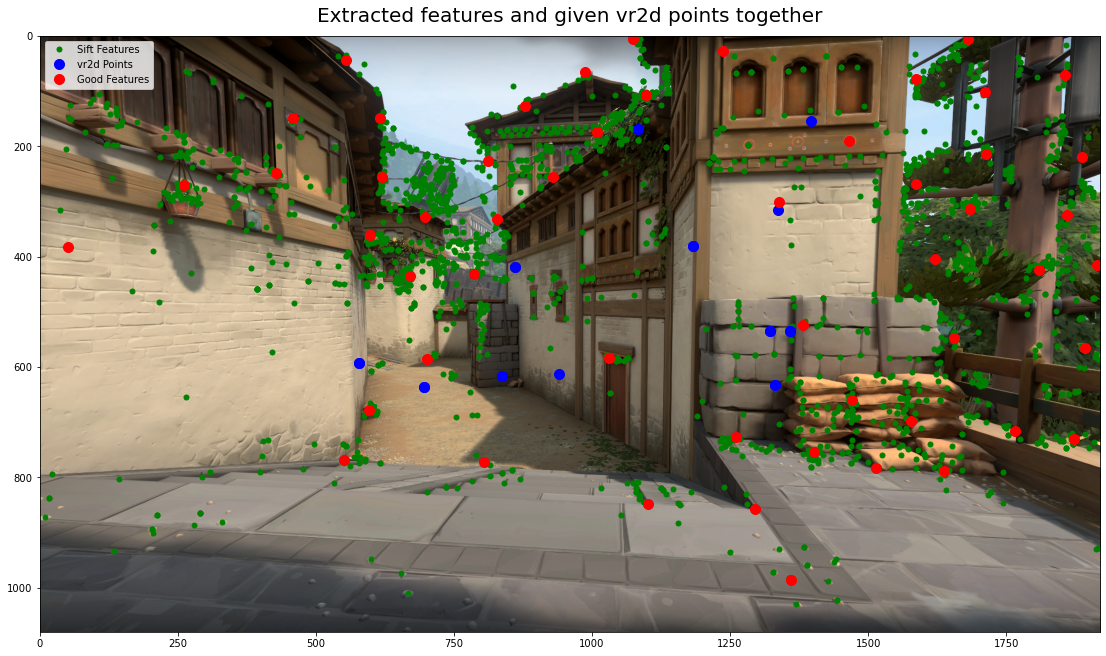

In [5]:
# extract good features to track from img1
gf_points = cv2.goodFeaturesToTrack(cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), maxCorners=200, qualityLevel=0.1, minDistance=100)
gf_points = gf_points.transpose(1,0,2)
print(gf_points.shape, 'good features extracted from img1')

# extract sift features from img1
sift = cv2.SIFT_create(2000) # max number of features to extract is restricted to 2000 only for visualization
kp1, des1 = sift.detectAndCompute(img1, None)
sift_points = np.array([kp1[i].pt for i in range(len(kp1))])
print(sift_points.shape, 'sift features extracted from img1')

# plot the extracted feature points and given vr2d points
plt.figure(figsize=(16,9), constrained_layout=True)
plt.suptitle('Extracted features and given vr2d points together', fontsize=20)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.plot(sift_points[:,0], sift_points[:,1], 'go', label='Sift Features', markersize=5)
plt.plot(points_2d[0,:,0], points_2d[0,:,1], 'bo', label='vr2d Points', markersize=10)
plt.plot(gf_points[0,:,0], gf_points[0,:,1], 'ro', label='Good Features', markersize=10)
plt.legend()
plt.show()

### First try: Match SIFT features and estimate Essential Matrix to use in recoveryPose
1. Calculate sift features on img2 and match with the ones in img1.
2. Estimate Essential Matrix
3. Recovery Pose from Essential Matrix

1026 matches found and masked 797 matches


No handles with labels found to put in legend.


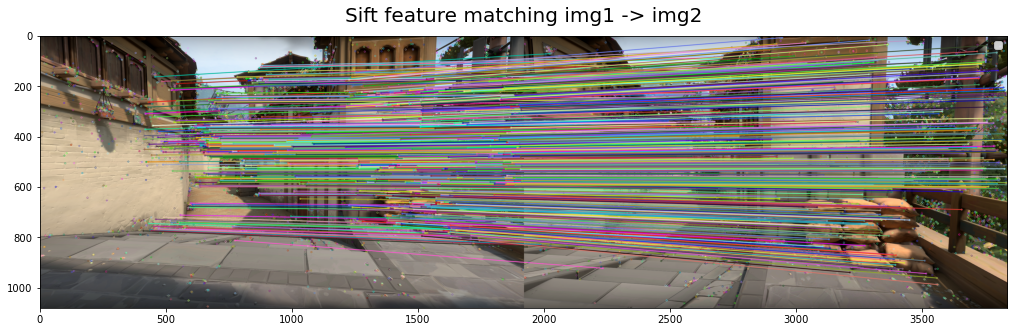

In [12]:
# extract sift features from img1
sift = cv2.SIFT_create() # max number of features to extract is restricted to 100 only for visualization
kp1, des1 = sift.detectAndCompute(img1, None)

# Extract sift features from img2 and match with the ones in img1
kp2, des2 = sift.detectAndCompute(img2, None)
matches = cv2.BFMatcher().knnMatch(des1, des2, k=2)
good = []
for m,n in matches:
    if m.distance < 0.8*n.distance:
        good.append(m)

# make homography estimation between img1 and img2
src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

EM, inliers_mask = cv2.findEssentialMat(src_pts, dst_pts, calibrated_camera_matrix.copy(), prob=0.999, threshold=1.0)
points, rvecs2, tvecs2, inliers_mask = cv2.recoverPose(EM, src_pts, dst_pts, calibrated_camera_matrix.copy(), mask=inliers_mask)
matchesMask = inliers_mask.ravel().tolist()

#matches = sorted(matches, key=lambda x:x.distance)
print(len(good), 'matches found and masked', np.sum(inliers_mask), 'matches')

out_img = cv2.drawMatches(img1, kp1, img2, kp2, good, None, matchesThickness=2, matchesMask=matchesMask)#, matchColor=(0,255,0))
plt.figure(figsize=(16,4.5), constrained_layout=True)
plt.suptitle('Sift feature matching img1 -> img2', fontsize=20)
plt.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))
plt.legend()
plt.show()

No handles with labels found to put in legend.


755 matches found and masked 531 matches


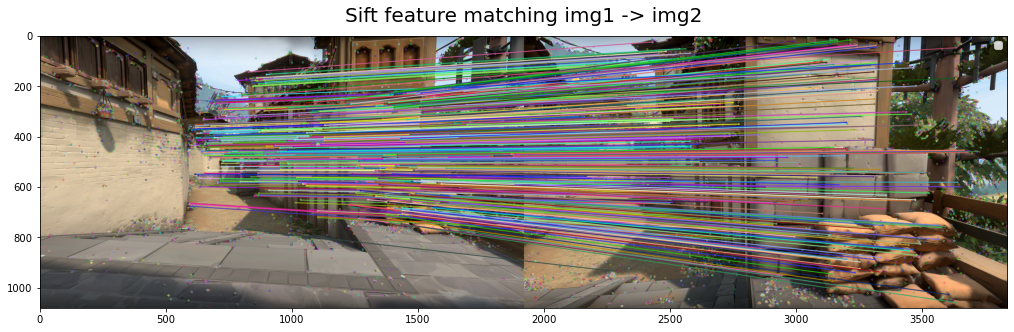

In [14]:
# extract sift features from img1
sift = cv2.SIFT_create() # max number of features to extract is restricted to 100 only for visualization
kp1, des1 = sift.detectAndCompute(img1, None)

# Extract sift features from img2 and match with the ones in img1
kp3, des3 = sift.detectAndCompute(img3, None)
matches = cv2.BFMatcher().knnMatch(des1, des3, k=2)
good = []
for m,n in matches:
    if m.distance < 0.8*n.distance:
        good.append(m)

# make homography estimation between img1 and img2
src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kp3[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

EM, inliers_mask = cv2.findEssentialMat(src_pts, dst_pts, calibrated_camera_matrix.copy(), prob=0.999, threshold=1.0)
points, rvecs3, tvecs3, inliers_mask = cv2.recoverPose(EM, src_pts, dst_pts, calibrated_camera_matrix.copy(), mask=inliers_mask)
matchesMask = inliers_mask.ravel().tolist()

#matches = sorted(matches, key=lambda x:x.distance)
print(len(good), 'matches found and masked', np.sum(inliers_mask), 'matches')

out_img = cv2.drawMatches(img1, kp1, img3, kp3, good, None, matchesThickness=2, matchesMask=matchesMask)#, matchColor=(0,255,0))
plt.figure(figsize=(16,4.5), constrained_layout=True)
plt.suptitle('Sift feature matching img1 -> img2', fontsize=20)
plt.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))
plt.legend()
plt.show()

### Calculate translations with scaling relative poses

In [17]:
# calibrate img2 with estimated vr2d points
print('retval: \n', calibrated[0]) # retval: the overall RMS re-projection error.
print('camera_matrix: \n', np.round(calibrated_camera_matrix, 2)) # camera_matrix after calibration.
print('distCoeffs: \n', np.round(calibrated_dist_coeffs, 3)) # distCoeffs: the vector of distortion coefficients.

import tabulate
from IPython.display import HTML, display
"""
rot = [['rvec1', 'rvec2', 'rvec3'],
            [rvecs1[0][0], rvecs2[0][0], rvecs3[0][0]],
            [rvecs1[1][0], rvecs2[1][0], rvecs3[1][0]],
            [rvecs1[2][0], rvecs2[2][0], rvecs3[2][0]]]

rotations = tabulate.tabulate(rot, headers='firstrow', tablefmt='html')
display(HTML(rotations))

"""

scale = 10
tr = [['tvec1', 'tvec2', 'tvec3'],
            [tvecs1[0][0], tvecs1[0][0] + scale * tvecs2[0][0], tvecs1[0][0] + scale * tvecs3[0][0]],
            [tvecs1[1][0], tvecs1[1][0] + scale * tvecs2[1][0], tvecs1[1][0] + scale * tvecs3[1][0]],
            [tvecs1[2][0], tvecs1[2][0] + scale * tvecs2[2][0], tvecs1[2][0] + scale * tvecs3[2][0]]]


translates = tabulate.tabulate(tr, headers='firstrow', tablefmt='html')
display(HTML(translates))

retval: 
 1.0414974089729807
camera_matrix: 
 [[761.96   0.   960.  ]
 [  0.   761.96 540.  ]
 [  0.     0.     1.  ]]
distCoeffs: 
 [[ 0.044 -0.257 -0.005  0.     0.268]]


tvec1,tvec2,tvec3
-5.0655,-12.8424,-7.13636
2.46047,2.46389,3.25366
5.57585,-0.710632,-4.17518


### Trajectory visualization

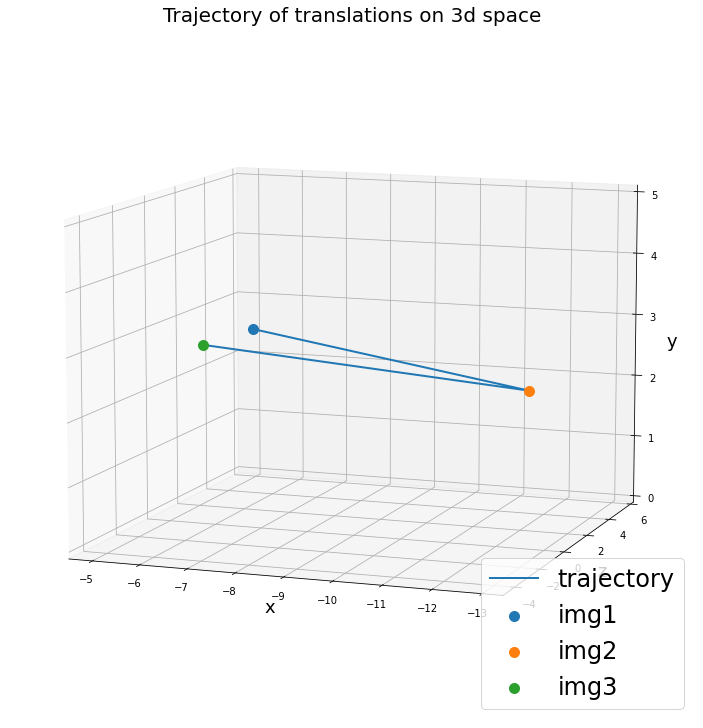

In [23]:
# plot trajectory of translations and rotations on 3d space
fig = plt.figure(figsize=(12, 10), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')

trs = np.array(tr[1:]).T
for i in range(3):
    ax.scatter(trs[i,0], trs[i,2], trs[i,1], marker='o', s=100, label=f'img{i+1}')

ax.plot(trs[:,0], trs[:,2], trs[:,1], '-', linewidth=2, label='trajectory')

ax.view_init(10, -70)
ax.set_xlabel("x", fontsize=18)
ax.set_ylabel("z", fontsize=18)
ax.set_zlabel("y", fontsize=18)
ax.set_zlim(0, 5)
ax.invert_xaxis()
fig.suptitle('Trajectory of translations on 3d space', fontsize=20)
plt.legend(loc='lower right', prop={'size': 24})
plt.savefig('3d_trajectory_try1.png')
plt.show()
